In [1]:
import os
import torchvision.transforms as transforms
import dlib
import numpy as np
import PIL
from PIL import Image
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt

In [2]:
def visualize(img_arr):
    plt.imshow(((img_arr.detach().numpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

def load_image(filename):
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5,0.5,0.5]),
    ])
    
    img = Image.open(filename)
    img = transform(img)
    return img.unsqueeze(dim=0)   

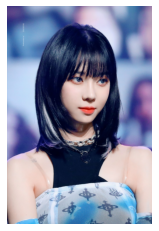

In [3]:
name = 'winter'
image_path = f'./data/{name}.png'
original_image = load_image(image_path)
# plt.figure(figsize=(10,10),dpi=30)
visualize(original_image[0])
# plt.show()

In [4]:
def get_landmark(filepath, predictor):
	"""get landmark with dlib
	:return: np.array shape=(68, 2)
	"""
	detector = dlib.get_frontal_face_detector()

	img = dlib.load_rgb_image(filepath)
	dets = detector(img, 1)

	for k, d in enumerate(dets):
		shape = predictor(img, d)

	t = list(shape.parts())
	a = []
	for tt in t:
		a.append([tt.x, tt.y])
	lm = np.array(a)
	return lm


def align_face(filepath, predictor):
	"""
	:param filepath: str
	:return: PIL Image
	"""

	lm = get_landmark(filepath, predictor)

	lm_chin = lm[0: 17]  # left-right
	lm_eyebrow_left = lm[17: 22]  # left-right
	lm_eyebrow_right = lm[22: 27]  # left-right
	lm_nose = lm[27: 31]  # top-down
	lm_nostrils = lm[31: 36]  # top-down
	lm_eye_left = lm[36: 42]  # left-clockwise
	lm_eye_right = lm[42: 48]  # left-clockwise
	lm_mouth_outer = lm[48: 60]  # left-clockwise
	lm_mouth_inner = lm[60: 68]  # left-clockwise

	# Calculate auxiliary vectors.
	eye_left = np.mean(lm_eye_left, axis=0)
	eye_right = np.mean(lm_eye_right, axis=0)
	eye_avg = (eye_left + eye_right) * 0.5
	eye_to_eye = eye_right - eye_left
	mouth_left = lm_mouth_outer[0]
	mouth_right = lm_mouth_outer[6]
	mouth_avg = (mouth_left + mouth_right) * 0.5
	eye_to_mouth = mouth_avg - eye_avg

	# Choose oriented crop rectangle.
	x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
	x /= np.hypot(*x)
	x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
	y = np.flipud(x) * [-1, 1]
	c = eye_avg + eye_to_mouth * 0.1
	quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
	qsize = np.hypot(*x) * 2

	# read image
	img = PIL.Image.open(filepath)

	output_size = 256
	transform_size = 256
	enable_padding = True

	# Shrink.
	shrink = int(np.floor(qsize / output_size * 0.5))
	if shrink > 1:
		rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
		img = img.resize(rsize, PIL.Image.ANTIALIAS)
		quad /= shrink
		qsize /= shrink

	# Crop.
	border = max(int(np.rint(qsize * 0.1)), 3)
	crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
			int(np.ceil(max(quad[:, 1]))))
	crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]),
			min(crop[3] + border, img.size[1]))
	if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
		img = img.crop(crop)
		quad -= crop[0:2]

	# Pad.
	pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
		   int(np.ceil(max(quad[:, 1]))))
	pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0),
		   max(pad[3] - img.size[1] + border, 0))
	if enable_padding and max(pad) > border - 4:
		pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
		img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
		h, w, _ = img.shape
		y, x, _ = np.ogrid[:h, :w, :1]
		mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w - 1 - x) / pad[2]),
						  1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h - 1 - y) / pad[3]))
		blur = qsize * 0.02
		img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
		img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
		img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
		quad += pad[:2]

	# Transform.
	img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
	if output_size < transform_size:
		img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

	# Save aligned image.
	return img

In [5]:
def run_alignment(image_path):
    # modelname = os.path.join(MODEL_DIR, 'shape_predictor_68_face_landmarks.dat')
    modelname = os.path.join('./modules/shape_predictor_68_face_landmarks.dat')
    predictor = dlib.shape_predictor(modelname)
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    return aligned_image

In [6]:
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)
device = 'cuda'
I = transform(run_alignment(image_path)).unsqueeze(dim=0).to(device)

C:\Users\nengcham\AppData\Local\Temp\ipykernel_7540\3900559881.py:102: DeprecationWarning: QUAD is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.QUAD instead.
  img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
C:\Users\nengcham\AppData\Local\Temp\ipykernel_7540\3900559881.py:102: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)


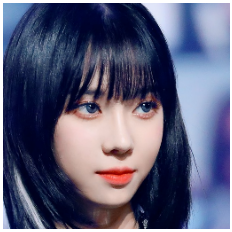

In [7]:
plt.figure(figsize=(10,10),dpi=30)
visualize(I[0].cpu())
plt.savefig(f'./data/{name}_align.png')